In [482]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
from keras.layers.advanced_activations import LeakyReLU
#from tensorflow.keras.utils import plot_model

# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [383]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    cats = []
    thresholds = [(0, 63), (1, 82), (2, 95), (3, 112), (4, 136), (5, 999)] # knots
    
    for path in paths:
        wind_speed = float(path['maxwind'])
        for it in thresholds:
            if wind_speed <= it[1]:
                category = it[0]
                break
        cats = np.append(cats, category)
    highest_cat = max(cats)
    return highest_cat

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    print (precips, " precips: ", temperatures)
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 200, 200)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    print (sst, " temperatures: ", temperatures)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 200, 200)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    print (colors, " rgbs: ", temperatures)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :200, :200]
    rgb_array = rgb_array.reshape(1, 48, 200, 200)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/noaa_sst_*.npy'

    sst = glob.glob(file, recursive = True)
    sst.sort()
    sst = sst[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, sst[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    
def createWindMap(profile):
    # return nparray(1, 200, 200)
    # hurricane center is  at (99,99),   each direction expand by 100 miles
    
    res = np.zeros((200, 200))
    
    maxwindradius = min(int(float(profile['maxwindradius'])), 99)
    maxwind = float(profile['maxwind'])
    
    keys = []
    for it in profile.keys():
        if 'kt' in it:
            keys.append(it)        
    keys.sort()
    
    for it in keys:
        if "ne" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100 +j] = max(0, float(it[:-4]))
        elif "se" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100 +j] = max(0, float(it[:-4]))
        elif "nw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100-j-1] = max(0, float(it[:-4]))
        elif "sw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100-j-1] = max(0, float(it[:-4]))
                        
    for i in range(-maxwindradius, maxwindradius):
        for j in range(-maxwindradius, maxwindradius):
            res[99 + i, 99 + j] = maxwind
    
    res = np.expand_dims(res, axis = 2)
                    
    return res
    

In [369]:
def getMaxWindDay(hurr_dict, day_list):
    high_day = None
    high_wind = 0
    for day in day_list: # for every day in a category for a hurricane:
        wind_speeds = np.asarray([])
        for path in hurr_dict: # for every path record in that hurricane's profile.json:
            if day == str(path['date']): # if the days match:
                if float(path['maxwind']) > high_wind: # compare this day's max wind to the highest speed for this category
                    high_wind = float(path['maxwind'])
                    high_day = day
    
    return high_day

def getCategory(wind_speed): # based on the Saffir-Simpson Scale for hurricane classification
    
    thresholds = [('TD', 33), ('TS', 63), ('Category_1', 82), ('Category_2', 95), ('Category_3', 112), ('Category_4', 136)]
    
    for it in thresholds:
        if wind_speed <= it[1]:
            return it[0]
    return thresholds[-1][0]

def selectDay(hurr_dict, cat_dictionary):
    pick_days = []
    for key in cat_dictionary.keys(): # for every category in the category dictionary:
        days = cat_dictionary[key]
        high_day = getMaxWindDay(hurr_dict, days) # find day in each category with the highest average wind speed
        pick_days = np.append(pick_days, high_day) # pick the first (0th index) day of that category
    print("pick days:", pick_days)
    return pick_days # a 1-D array containing the first day that the hurricane reaches a new category.

def lastDay(hurr_dict):
    return None # will pick last day in path, 

def getStageByDay(folder, day):
    
    imerg_names = folder + '/imerg_precipitation_' + day + '_*.npy'
    sst_names = folder + '/noaa_sst_' + day + '*.npy'
    rgb_names = folder + '/10_wavelet_rgb_' + day + '*.npy'
    #rgb_names = folder + '/10_modis_satellite_' + day + '*.npy'
    
    profile_name = folder + '/profile.json'
    f = open(profile_name)
    profile = json.load(f)
    paths = profile['path']

    imergs = glob.glob(imerg_names, recursive = True)
    ssts = glob.glob(sst_names, recursive = True)
    rgbs = glob.glob(rgb_names, recursive = True)
    
    imerg_array = np.zeros((200, 200))
    for imerg in imergs:
        im_arr = np.load(imerg)
        if not (sizeCheck(im_arr)):
            continue
        imerg_array = imerg_array + np.load(imerg)

    imerg_array = imerg_array.reshape(200, 200, 1)
    imerg_array = imerg_array / len(imergs)
    
    if (not rgbs) or (not ssts):
        #print("no rgbs or ssts: ", folder, day)
        return None
    
    
    sst_array = np.load(ssts[0])
    print("sst:", sst_array.shape)
    
    if (not sizeCheck(sst_array)) or (not sizeCheck(imerg_array)):      
        #print("sst shape invalid: ", folder, day)
        return None

    sst_array = sst_array.reshape(200, 200, 1)
    
    rgb_array = np.load(rgbs[0])
    
    #rgb_array = rgb_array[100:300, 100:300, :]
    rgb_array = rgb_array[1:201, 1:201, :]
    print(folder, day, "- rgb:", rgb_array.shape)
    rgb_array = ((rgb_array * 10000 + 100) / 66.66)*1.5


    rgb_array = rgb_array.astype(int)

    rgb_array[rgb_array < 0] = 0
    rgb_array[rgb_array > 255] = 255
        
    selected_days = []

    for path in paths:
        if path['date'] == int(day):
            selected_days.append(path)
        
    # pick mid element from path    
    middleIndex = int((len(selected_days) - 1)/2)
    if len(selected_days) == 2: 
        middleIndex = 1
        
    selected_day = selected_days[middleIndex]

    wind_array = createWindMap(selected_day)
    
    stage_array = imerg_array
    stage_array = np.dstack((stage_array, sst_array))
    stage_array = np.dstack((stage_array, rgb_array))
    stage_array = np.dstack((stage_array, wind_array))
    stage_array = np.expand_dims(stage_array, axis = 0)
    
    return stage_array

def sizeCheck(tensor): # size check should happen after stage data is collected
    shape = len(tensor.flatten())
    if shape != 40000:
        return False
    else:
        return True
    
def populateStage(stage, step):
    if step is None:
        return stage
    if stage is None:
        stage = step
    else:
        stage = np.append(stage, step, axis = 0)
    return stage

In [398]:
def completeDataCollection(globname, img_size, hours_early, max_wind_param, landed_only): # NEW DATA COLLECTION METHOD - SORT INTO STAGES

    folders = glob.glob(globname, recursive = True)
    # AL032000, failed rgb glob (no modis satellite data for that day)
    # AL242005, failed ssts glob (no sst satellite data for that day)
    stage_1 = None
    stage_2 = None
    stage_3 = None
    highest_cat = None

    for folder in folders:
    
        name = folder + '/profile.json'
        f = open(name)
        prof = json.load(f)
        paths = prof['path']
        
        print(folder)
        '''
        if landed_only:
            if "landed" not in prof.keys() or not prof['landed']:
                continue
        '''
        cats = {} # dictionary with categories as keys, days as values.
        # used to extract day values based on hurricane category (stage)
        
        remove = int((int(hours_early)-6)/6) # number of 6-hourly path records to remove from profile.json
        paths = paths[:-remove] # removal is done in-place
        
        for path in paths:
            if int(path['maxwind']) < int(max_wind_param): # only select hurricanes with wind speed at least max_wind_param
                continue
            # getCategory will take the max wind of every day in a hurricane's path and turn it into a category
                # based on the Saffir-Simpson Scale
            test = getCategory(int(path['maxwind']))

            if test not in cats.keys():
                cats[test] = []
            cats[test].append(str(path['date']))

        for key in cats.keys():
            cats[key] = list(set(cats[key]))
            cats[key].sort()
        
        # the category dictionary is used to select a day
        days = selectDay(paths, cats) # pass the profile.json of the hurricane to selectDay
            # selectDay will then pass the profile to getMaxWindDay
            # getMaxWindDay will use the profile combined with the cat_dictionary to get the day with highest wind

        if len(days) < 3:
            #print("not enough categories: ", folder)
            continue
        #print("valid folder: ", folder)

        # this is the part of the model that selects the category
        # the step before this, selectDays(cat_dictionary), takes the list of days in a hurricane,
            # which is already sorted with a dictionary by category, and picks the middle day in each category's list
            # to produce days, which is used in this step.
        step_1 = getStageByDay(folder, days[-3]) # third last day (category)
        step_2 = getStageByDay(folder, days[-2]) # second last
        step_3 = getStageByDay(folder, days[-1]) # last (strongest category)


        if (step_1 is None) or (step_2 is None) or (step_3 is None):
            #print("size not fit: ", folder)
            continue

        highest_cat = np.append(highest_cat, get_max_wind(folder))
        
        stage_1 = populateStage(stage_1, step_1)
        stage_2 = populateStage(stage_2, step_2)
        stage_3 = populateStage(stage_3, step_3)
        
        print("APPENDED", folder)

        

    highest_cat = highest_cat[1:]
    
    # original tensor size along dimensions 1 and 2 is 200x200
    length = stage_1.shape[1]
    padding = int((length - img_size)/2)
    
    stage_1 = stage_1[:, padding:length-padding, padding:length-padding, :]
    stage_2 = stage_2[:, padding:length-padding, padding:length-padding, :]
    stage_3 = stage_3[:, padding:length-padding, padding:length-padding, :]
    
    print(#stage_1.shape, 
      #stage_2.shape,
      stage_3.shape, 
      highest_cat.shape
     )
    
    return stage_1, stage_2, stage_3, highest_cat



In [399]:
stage_1, stage_2, stage_3, highest_cat = completeDataCollection('/home/fun/data/AL*20*', 100, 24, 0, True)

/home/fun/data/AL022004
pick days: ['20040809' '20040811']
/home/fun/data/AL042004
pick days: ['20040820' '20040818' '20040815' '20040816']
sst: (1, 200, 200)
/home/fun/data/AL042004 20040818 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL042004 20040815 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL042004 20040816 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL042004
/home/fun/data/AL052004
pick days: ['20040814' '20040814']
/home/fun/data/AL072004
pick days: ['20040828' '20040828']
/home/fun/data/AL082004
pick days: ['20040829' '20040830']
/home/fun/data/AL102004
pick days: ['20040909']
/home/fun/data/AL112004
pick days: []
/home/fun/data/AL072006
pick days: ['20060905' '20060910' '20060910']
sst: (1, 200, 200)
/home/fun/data/AL072006 20060905 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL072006 20060910 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL072006 20060910 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL072006
/home/fun/data/AL

APPENDED /home/fun/data/AL122002
/home/fun/data/AL132002
pick days: ['20020927' '20020930' '20021001' '20021002' '20021002' '20021002']
sst: (1, 200, 200)
/home/fun/data/AL132002 20021002 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL132002 20021002 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL132002 20021002 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL132002
/home/fun/data/AL142002
pick days: ['20021014']
/home/fun/data/AL012003
pick days: ['20030426' '20030421']
/home/fun/data/AL022003
pick days: ['20030611']
/home/fun/data/AL032003
pick days: ['20030629' '20030630']
/home/fun/data/AL042003
pick days: ['20030707' '20030710' '20030710']
sst: (1, 200, 200)
/home/fun/data/AL042003 20030707 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL042003 20030710 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL042003 20030710 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL042003
/home/fun/data/AL052003
pick days: ['20030720' '20030718' '20030718']


APPENDED /home/fun/data/AL252005
/home/fun/data/AL262005
pick days: ['20051023' '20051023']
/home/fun/data/AL272005
pick days: ['20051027' '20051029' '20051029']
sst: (1, 200, 200)
/home/fun/data/AL272005 20051027 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL272005 20051029 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL272005 20051029 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL272005
/home/fun/data/AL282005
pick days: ['20051120' '20051119']
/home/fun/data/AL292005
pick days: ['20051120' '20051124']
/home/fun/data/AL302005
pick days: ['20051202' '20051205' '20051208']
/home/fun/data/AL312005
pick days: ['20051230' '20060101']
/home/fun/data/AL012006
pick days: ['20060610' '20060612']
/home/fun/data/AL022006
pick days: ['20060717' '20060717']
/home/fun/data/AL032006
pick days: ['20060718' '20060719']
/home/fun/data/AL042006
pick days: ['20060801' '20060802']
/home/fun/data/AL052006
pick days: ['20060826' '20060823']
/home/fun/data/AL062006
pick days: ['2006

APPENDED /home/fun/data/AL072009
/home/fun/data/AL082009
pick days: ['20090925']
/home/fun/data/AL092009
pick days: ['20090927']
/home/fun/data/AL102009
pick days: ['20091006' '20091007']
/home/fun/data/AL112009
pick days: ['20091104' '20091104']
/home/fun/data/AL012010
pick days: ['20100625']
/home/fun/data/AL022010
pick days: ['20100707']
/home/fun/data/AL032010
pick days: ['20100722' '20100722']
/home/fun/data/AL042010
pick days: ['20100803' '20100805']
/home/fun/data/AL052010
pick days: ['20100810']
/home/fun/data/AL062010
pick days: ['20100822' '20100830' '20100826' '20100827' '20100827' '20100827']
sst: (1, 200, 200)
/home/fun/data/AL062010 20100827 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL062010 20100827 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL062010 20100827 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL062010
/home/fun/data/AL072010
pick days: ['20100825' '20100829' '20100903' '20100830' '20100902' '20100902']
sst: (1, 200, 200)
/home/fun/d

APPENDED /home/fun/data/AL122012
/home/fun/data/AL132012
pick days: ['20120904' '20120905' '20120906' '20120906' '20120906']
sst: (1, 200, 200)
/home/fun/data/AL132012 20120906 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL132012 20120906 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL132012 20120906 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL132012
/home/fun/data/AL142012
pick days: ['20120911' '20121001' '20120930']
sst: (1, 200, 200)
/home/fun/data/AL142012 20120911 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL142012 20121001 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL142012 20120930 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL142012
/home/fun/data/AL152012
pick days: ['20121003' '20121004']
/home/fun/data/AL162012
pick days: ['20121011' '20121012']
/home/fun/data/AL172012
pick days: ['20121015' '20121016' '20121024']
sst: (1, 200, 200)
/home/fun/data/AL172012 20121015 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data

APPENDED /home/fun/data/AL082017
/home/fun/data/AL092017
pick days: ['20170817']
/home/fun/data/AL112017
pick days: ['20170830' '20170831' '20170831' '20170902' '20170904' '20170905']
sst: (1, 200, 200)
/home/fun/data/AL112017 20170902 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL112017 20170904 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL112017 20170905 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL112017
/home/fun/data/AL122017
pick days: ['20170905' '20170906' '20170907' '20170907' '20170908' '20170908']
/home/fun/data/AL132017
pick days: ['20170906' '20170906' '20170908']
/home/fun/data/AL142017
pick days: ['20170920' '20170924' '20170926' '20170927' '20170927']
/home/fun/data/AL152017
pick days: ['20170916' '20170917' '20170918']
/home/fun/data/AL162017
pick days: ['20171003']
/home/fun/data/AL172017
pick days: ['20171008' '20171011' '20171013' '20171014' '20171014']
/home/fun/data/AL182017
pick days: ['20171027']
/home/fun/data/AL192017
pick days: ['2

APPENDED /home/fun/data/AL312020
/home/fun/data/AL012021
pick days: ['20210520' '20210521']
/home/fun/data/AL022021
pick days: ['20210614' '20210615']
/home/fun/data/AL032021
pick days: ['20210618' '20210618']
/home/fun/data/AL042021
pick days: ['20210627']
/home/fun/data/AL052021
pick days: ['20210630' '20210702' '20210702']
sst: (1, 200, 200)
/home/fun/data/AL052021 20210630 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL052021 20210702 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL052021 20210702 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL052021
/home/fun/data/AL062021
pick days: ['20210813' '20210816']
/home/fun/data/AL072021
pick days: ['20210814' '20210818' '20210818']
sst: (1, 200, 200)
/home/fun/data/AL072021 20210814 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL072021 20210818 - rgb: (200, 200, 44)
sst: (1, 200, 200)
/home/fun/data/AL072021 20210818 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL072021
/home/fun/data/AL082021
pick days

In [418]:
highest_cat
ohe_cats = np.zeros((len(highest_cat), int(highest_cat.max())))

for idx, cat in enumerate(highest_cat): 
    ohe_cats[idx, int(cat)-1] = 1
    
# transform highest category (1-5) into one-hot encoded array
# 1 --> [1, 0, 0, 0, 0]
# 5 --> [0, 0, 0, 0, 1]

# allows our neural network to perform multi-class classification with multiple output nodes
# softmax activation function will make the model output positive probabilities for each category

In [401]:
stages = [stage_1, stage_2, stage_3]

for stage in stages:
    for i in range(stage.shape[0]):
        for j in range(stage.shape[3]):
            scaler = StandardScaler()
            scaler.fit(stage[i, :, :, j])
            stage[i, :, :, j] = scaler.transform(stage[i, :, :, j])
        
print(stage_1.shape, stage_2.shape, stage_3.shape)

(109, 100, 100, 47) (109, 100, 100, 47) (109, 100, 100, 47)


In [419]:
ohe_cats = ohe_cats.astype("float32")

stage_1 = stage_1.astype("float32")
#stage_1 = np.swapaxes(stage_1, 1, 2)
#stage_1 = np.swapaxes(stage_1, 2, 3)

stage_2 = stage_2.astype("float32")
#stage_2 = np.swapaxes(stage_2, 1, 2)
#stage_2 = np.swapaxes(stage_2, 2, 3)

stage_3 = stage_3.astype("float32")
#stage_3 = np.swapaxes(stage_3, 1, 2)
#stage_3 = np.swapaxes(stage_3, 2, 3)

print(stage_1.shape, stage_2.shape, stage_3.shape)

(109, 100, 100, 47) (109, 100, 100, 47) (109, 100, 100, 47)


In [426]:
# img
indices = np.arange(0, stage_1.shape[0], 1)
print(len(indices))
print(len(ohe_cats))

index_train, index_test, y_train, y_test = train_test_split(
    indices, ohe_cats, train_size = 0.8, random_state = 3489)

stage_1_train = None
stage_1_test = None

for i in index_train: # get shuffled training datasets
    if stage_1_train is None:
        stage_1_train = stage_1[i:i+1, :, :, :] # i:i+1 to force shape of a 4D tensor, doesn't change index values
        stage_2_train = stage_2[i:i+1, :, :, :]
        stage_3_train = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_train = np.append(stage_1_train, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_train = np.append(stage_2_train, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_train = np.append(stage_3_train, stage_3[i:i+1, :, :, :], axis = 0)

for i in index_test: # get shuffled testing datasets
    if stage_1_test is None:
        stage_1_test = stage_1[i:i+1, :, :, :]
        stage_2_test = stage_2[i:i+1, :, :, :]
        stage_3_test = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_test = np.append(stage_1_test, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_test = np.append(stage_2_test, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_test = np.append(stage_3_test, stage_3[i:i+1, :, :, :], axis = 0)

print(stage_1_train.shape, len(y_train))
print(stage_1_test.shape, len(y_test))

109
109
(87, 100, 100, 47) 87
(22, 100, 100, 47) 22


In [517]:
# stage 1 of hurricane development -- early input data

#channels = 47
#img_size = 100

def create_cnn_model(image_size, channels, num_of_stages):
    
    layers = []  # element of this list is a dictinoary keyed by 'input', 'conv', 'pool'
    flat_list = []
    input_list = []
    
    for i in range(num_of_stages):
        it = {}
        it['input'] = Input(shape = (image_size, image_size, channels),
                      name = 'stage' + str(i+1) + '_input')
        
        it['conv'] = Conv2D(filters = 12, 
               kernel_size = (11, 11), 
               activation = "relu", 
               padding = "same", 
               name = 'stage' + str(i+1) + '_conv')(it['input'])
        
        it['pool'] = AveragePooling2D(pool_size = (2, 2), 
                         strides = 2,
                         name = 'stage' + str(i+1) + '_pool')(it['conv'])
        
        it['batch'] = BatchNormalization(name = 'stage' + str(i+1) +'_batch1')(it['pool'])
        
        it['conv2'] = Conv2D(filters = 12, 
               kernel_size = (11, 11), 
               activation = "relu", 
               padding = "same", 
               name = 'stage' + str(i+1) + '_conv2')(it['batch'])
        
        
        it['pool2'] = AveragePooling2D(pool_size = (2, 2), 
                         strides = 2,
                         name = 'stage' + str(i+1) + '_pool2')(it['conv2'])

        it['batch2'] = BatchNormalization(name = 'stage' + str(i+1) +'_batch2')(it['pool2'])

        it['flat']  = Flatten(name = 'stage' + str(i+1) + '_flat')(it['batch2'])
        
        layers.append(it)
        
        flat_list.append(it['flat'])
        input_list.append(it['input'])
        
    # dense layers -- feature training
    concat = concatenate(flat_list)

    dense1 = Dense(128, activation = keras.layers.LeakyReLU(alpha = 0.3), 
                   name = 'Fully_Connected_1')(concat)
    dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

    dense2 = Dense(64, activation = keras.layers.LeakyReLU(alpha = 0.3),
                   name = 'Fully_Connected_2')(dense1dropout)
    dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

    output = Dense(5, activation = "softmax", name = 'Output_Layer')(dense2dropout)

    # create model with two inputs
    model = Model(input_list, output)
    return model


In [523]:
# fully connected layers for max wind predictor

'''
dense1 = Dense(128, activation = keras.layers.ReLU, 
               name = 'Fully_Connected_1')(concat)
dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

dense2 = Dense(64, activation = keras.layers.ReLU,
               name = 'Fully_Connected_2')(dense1dropout)
dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

output = Dense(5, activation = keras.layers.ReLU, name = 'Output_Layer')(dense2dropout)
'''

# compiler for max wind predictor
'''
three_stage_model.compile(
    loss = tf.keras.losses.MeanSquareError(), 
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.0005
    ),
    metrics = tf.keras.metrics.RootMeanSquaredError()
)
'''

'\nthree_stage_model.compile(\n    loss = tf.keras.losses.MeanSquareError(), \n    optimizer = tf.keras.optimizers.Adam(\n        learning_rate = 0.0005\n    ),\n    metrics = tf.keras.metrics.RootMeanSquaredError()\n)\n'

In [518]:

three_stage_model = create_cnn_model(100, 47, 3)
three_stage_model.summary()


Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stage1_input (InputLayer)       [(None, 100, 100, 47 0                                            
__________________________________________________________________________________________________
stage2_input (InputLayer)       [(None, 100, 100, 47 0                                            
__________________________________________________________________________________________________
stage3_input (InputLayer)       [(None, 100, 100, 47 0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 100, 100, 12) 68256       stage1_input[0][0]               
___________________________________________________________________________________________

In [430]:
one_stage_model = create_cnn_model(100, 47, 1)
one_stage_model.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stage1_input (InputLayer)    [(None, 100, 100, 47)]    0         
_________________________________________________________________
stage1_conv (Conv2D)         (None, 100, 100, 12)      68256     
_________________________________________________________________
stage1_pool (AveragePooling2 (None, 50, 50, 12)        0         
_________________________________________________________________
stage1_batch1 (BatchNormaliz (None, 50, 50, 12)        48        
_________________________________________________________________
stage1_conv2 (Conv2D)        (None, 50, 50, 12)        17436     
_________________________________________________________________
stage1_pool2 (AveragePooling (None, 25, 25, 12)        0         
_________________________________________________________________
stage1_batch2 (BatchNormaliz (None, 25, 25, 12)        48 

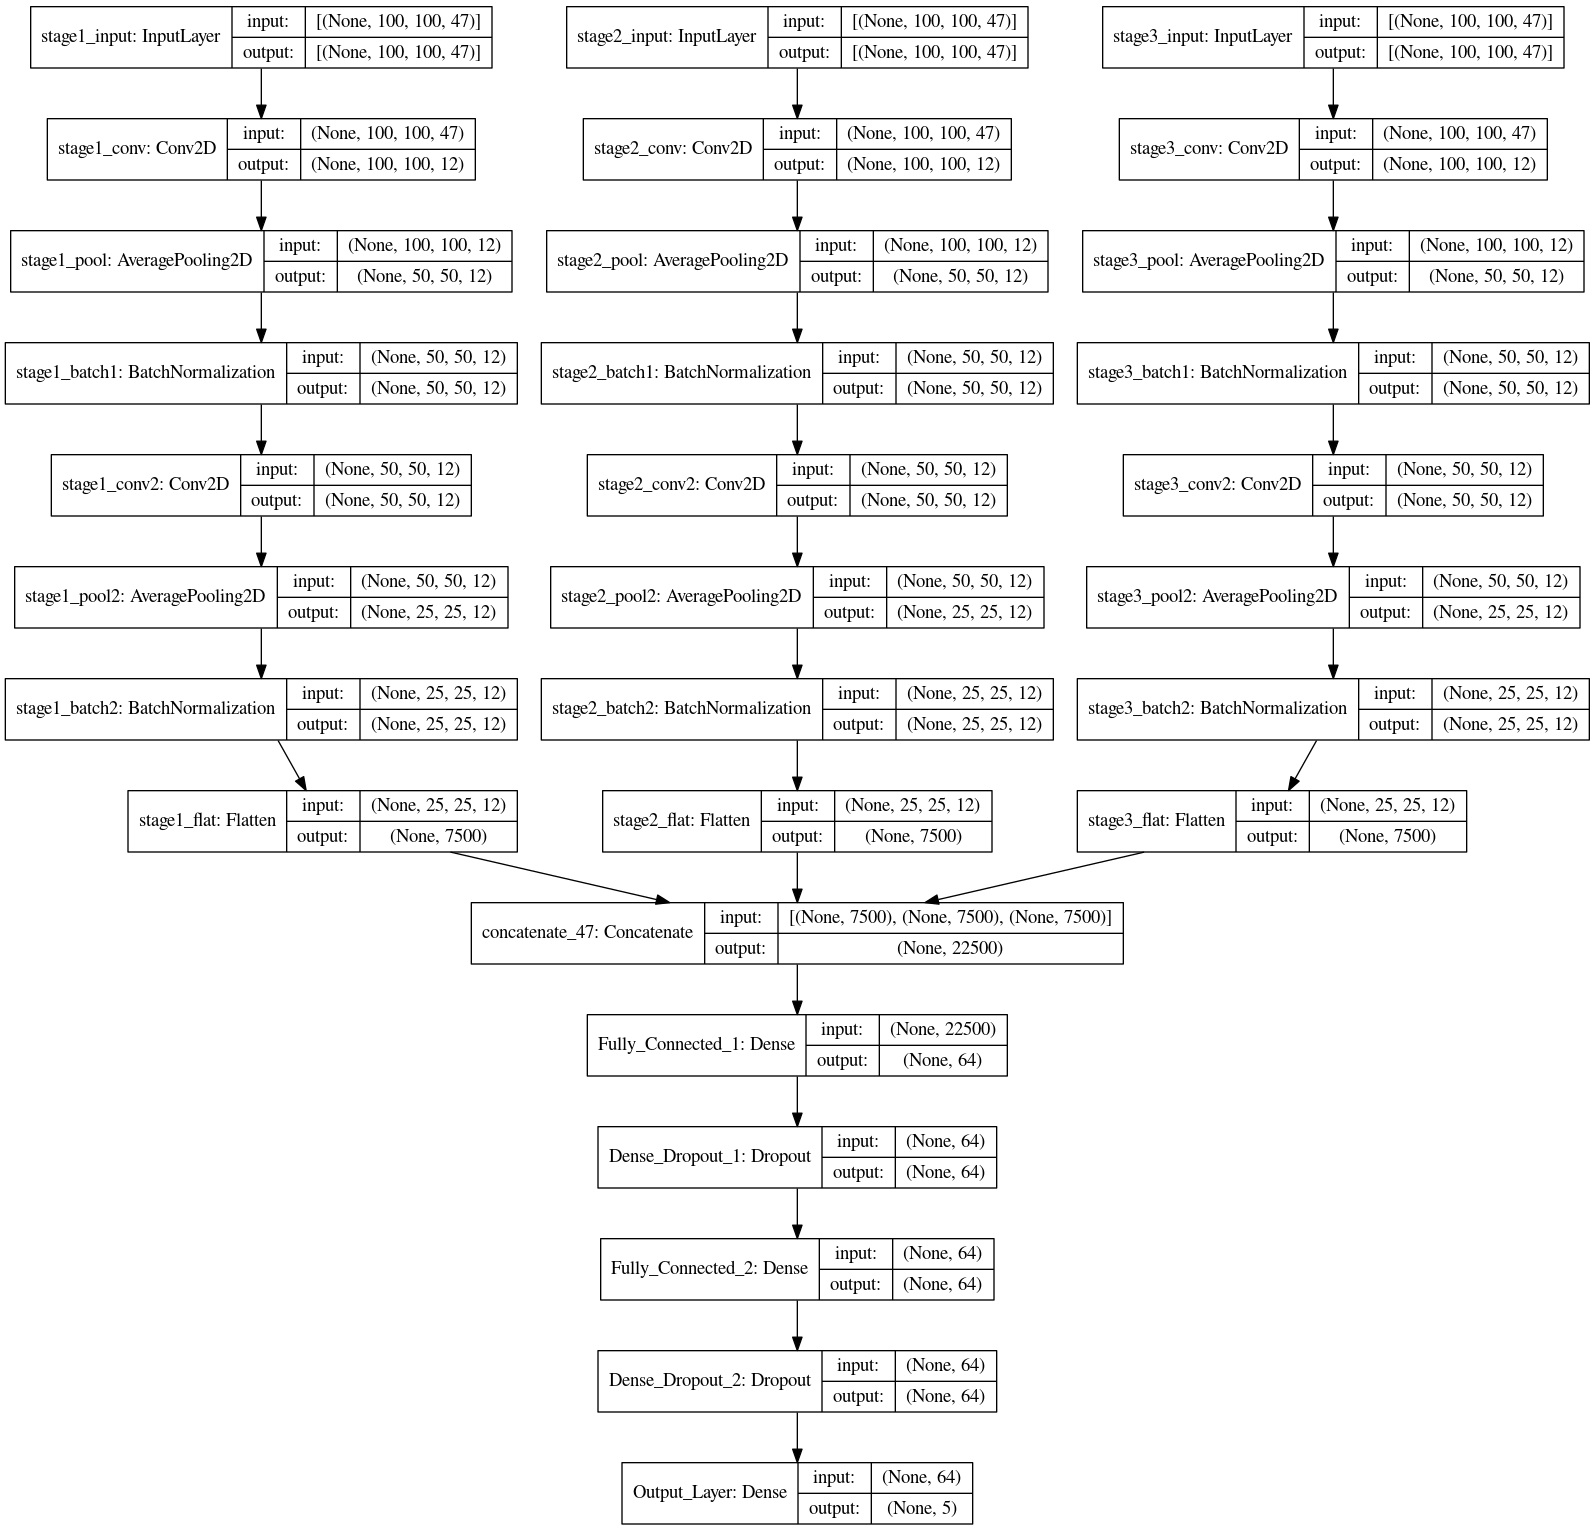

In [496]:
tf.keras.utils.plot_model(three_stage_model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/15
18/18 [==============================] - 28s 2s/step - loss: 2.8209 - acc: 0.2759 - val_loss: 1.4575 - val_acc: 0.5455
Epoch 2/15
18/18 [==============================] - 27s 1s/step - loss: 1.1146 - acc: 0.6207 - val_loss: 1.3635 - val_acc: 0.5909
Epoch 3/15
18/18 [==============================] - 27s 1s/step - loss: 0.8767 - acc: 0.7011 - val_loss: 1.3307 - val_acc: 0.5909
Epoch 4/15
18/18 [==============================] - 27s 1s/step - loss: 0.8390 - acc: 0.7126 - val_loss: 1.2501 - val_acc: 0.6364
Epoch 5/15
18/18 [==============================] - 27s 1s/step - loss: 0.3887 - acc: 0.8851 - val_loss: 1.2621 - val_acc: 0.5455
Epoch 6/15
18/18 [==============================] - 27s 1s/step - loss: 0.5540 - acc: 0.7816 - val_loss: 1.3283 - val_acc: 0.5000
Epoch 7/15
18/18 [==============================] - 27s 1s/step - loss: 0.1887 - acc: 0.9310 - val_loss: 1.3710 - val_acc: 0.5455
Epoch 8/15
18/18 [==============================] - 27s 1s/step - loss: 0.2539 - acc: 0.89

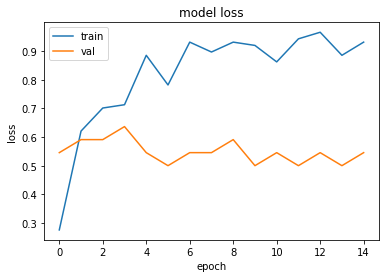

In [519]:
three_stage_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.RMSprop(
        learning_rate = 1e-4
    ),
    metrics = ['acc']
)

history = three_stage_model.fit([
    stage_1_train, 
    stage_2_train, 
    stage_3_train
], y_train, 
          batch_size = 5, 
          epochs = 15, 
          validation_data = ([
              stage_1_test, 
              stage_2_test, 
              stage_3_test
          ], y_test), 
          )

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')






In [509]:
# for MULTICLASS EVALOATION ONLY

def softmaxToCat(y_pred):
    res = []
    for row in y_pred:
        res = np.append(res, row.argmax()+1)
    return res

def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("multiclass confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 5.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

[2. 2. 1. 2. 1. 3. 5. 2. 1. 1. 5. 2. 1. 3. 1. 4. 4. 3. 1. 1. 1. 4.] [3. 3. 1. 3. 1. 4. 4. 2. 1. 1. 4. 4. 1. 3. 1. 4. 1. 3. 3. 1. 1. 1.]
              precision    recall  f1-score   support

         1.0       0.80      0.89      0.84         9
         2.0       1.00      0.20      0.33         5
         3.0       0.33      0.67      0.44         3
         4.0       0.20      0.33      0.25         3
         5.0       1.00      0.00      0.00         2

    accuracy                           0.55        22
   macro avg       0.67      0.42      0.37        22
weighted avg       0.72      0.55      0.51        22



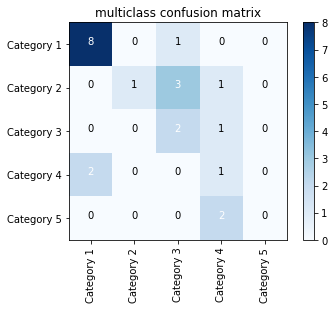

In [520]:
y_pred = three_stage_model.predict([stage_1_test, 
                        stage_2_test, 
                        stage_3_test])

y_pred_res = softmaxToCat(y_pred)
y_test_res = softmaxToCat(y_test)

print(y_test_res, y_pred_res)
draw_confusion_matrix(y_test_res, y_pred_res, ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5'])
print(classification_report(y_test_res, y_pred_res, zero_division = True))

[3. 3. 1. 4. 4. 1. 1. 2. 1. 4. 1. 3. 4. 1. 4. 3. 4. 3. 4. 1. 2. 1. 1. 1.
 3. 3. 1. 3. 5. 5. 4. 3. 5. 4. 4. 4. 2. 4. 5. 5. 4. 1. 2. 1. 1. 5. 4. 2.
 2. 1. 3. 4. 1. 1. 1. 3. 1. 4. 4. 1. 1. 3. 1. 3. 4. 3. 1. 1. 4. 3. 4. 2.
 4. 1. 1. 3. 1. 2. 1. 3. 4. 1. 4. 3. 1. 1. 4.] [3. 3. 1. 4. 4. 1. 1. 2. 1. 4. 1. 3. 4. 1. 4. 3. 4. 3. 4. 1. 2. 1. 1. 1.
 3. 3. 1. 3. 5. 5. 4. 3. 5. 4. 4. 4. 2. 4. 5. 5. 4. 1. 2. 1. 1. 5. 4. 2.
 2. 1. 3. 4. 1. 1. 1. 3. 1. 4. 4. 1. 1. 3. 1. 3. 4. 3. 1. 1. 4. 3. 4. 2.
 4. 1. 1. 3. 1. 2. 1. 3. 4. 1. 4. 3. 1. 1. 4.]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        31
         2.0       1.00      1.00      1.00         8
         3.0       1.00      1.00      1.00        18
         4.0       1.00      1.00      1.00        24
         5.0       1.00      1.00      1.00         6

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00 

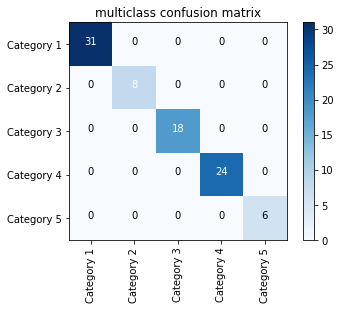

In [522]:
y_train_pred = three_stage_model.predict([
    stage_1_train, 
    stage_2_train, 
    stage_3_train])

y_train_pred = softmaxToCat(y_train_pred)
y_train_res = softmaxToCat(y_train)

print(y_train_pred, y_train_res)
draw_confusion_matrix(y_train_res, y_train_pred, ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5'])
print(classification_report(y_train_res, y_train_pred, zero_division = True))

on average, the model's prediction is 96.85155153274536 % off of the true max wind speed.
the standard deviation of the error is 83.21052525273778 knots/hr.


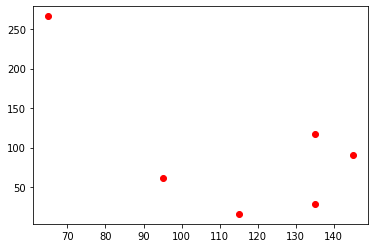

In [362]:
import math

percent_error = 0
err_vals = []


for i in range(len(y_test)):
    err = ((y_pred[i] - y_test[i])/y_pred[i])*100
    err_vals = np.append(err_vals, abs(err))
    percent_error = percent_error + abs(err)

mean_error = percent_error/len(y_test)

std_dev_err = err_vals - mean_error
std_dev_err = np.power(std_dev_err, 2)
std_dev_sum = np.sum(std_dev_err)

std_dev = math.sqrt(std_dev_sum/len(err_vals))

print("on average, the model's prediction is", mean_error, "% off of the true max wind speed.")
print("the standard deviation of the error is", std_dev, "knots/hr.")

plt.plot(y_test, err_vals, "ro")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(24, 200, 200, 47)
(200, 200, 47)
(200, 200, 3)


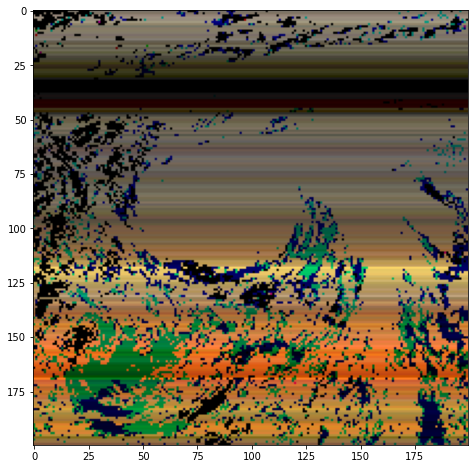

In [232]:
'''
stage_array = imerg_array #0
stage_array = np.dstack((stage_array, sst_array)) #1
stage_array = np.dstack((stage_array, rgb_array)) #2-45
stage_array = np.dstack((stage_array, wind_array)) #47
stage_array = np.expand_dims(stage_array, axis = 0)
'''

print(stage_3_test.shape)

#idx = np.where(y_pred=='nan')[0][0]
#print(idx)
test = stage_3_train[3]
print(test.shape)

R_app = test[:, :, 2] # red band
B_app = test[:, :, 10] # blue band
G_app = test[:, :, 14] # green band

#R_app = R_app * 0.001
#B_app = B_app * 0.001
#G_app = G_app * 0.001

color = np.dstack([R_app, G_app, B_app])
print(color.shape)

plt.figure(figsize = (8, 8))
plt.imshow(color)
plt.show()

In [24]:
# outdated data collection methodology -- moved on as of 11/08/2022
def OUTDATED_DATA_COLLECTION():
    highest_wind = np.empty([0])
    imerg_precip = np.empty([1, 10, 200, 200])
    skin_temp = np.empty([1, 4, 200, 200])
    dwt_rgb = np.empty([1, 48, 200, 200])

    all_folders = glob.glob('/home/fun/data/AL*20*')
    all_folders.sort()

    len_fail = 0
    land_fail = 0

    for folder in all_folders:
        imerg_names = folder + '/imerg_precipitation_*.npy'
        sst_names = folder + '/noaa_sst_*.npy'
        rgb_names = folder + '/wavelet_rgb_*.npy'

        if not lenCheck(imerg_names, sst_names, rgb_names):
            print("skipping lenCheck ", folder)
            len_fail += 1
            continue
        if not landCheck(folder, imerg_names, sst_names, rgb_names):
            print("skipping landCheck ", folder)
            land_fail += 1
            continue

        imerg_precip = np.append(imerg_precip, get_imerg(imerg_names), axis = 0) # X data (train class)
        skin_temp = np.append(skin_temp, get_sst(sst_names), axis = 0) # X data (train class)
        dwt_rgb = np.append(dwt_rgb, get_rgb(rgb_names), axis = 0)

        highest_wind = np.append(highest_wind, get_max_wind(folder)) # Y data (target class)

    imerg_precip = imerg_precip[1:]
    skin_temp = skin_temp[1:]
    dwt_rgb = dwt_rgb[1:]

    print(imerg_precip.shape, skin_temp.shape, dwt_rgb.shape, highest_wind.shape)
    print("len_fail: ", len_fail)
    print("land_fail: ", land_fail)
    
    return None # OUTDATED DATA COLLECTION METHOD AS OF 11/08/2022